In [1]:
import numpy as np
from scipy.linalg import null_space
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from src.prw import PRW
from src.sinkhorn import RBCD

In [2]:
d = 3

n = 5
m = 5

k_star = 5
k = 2

In [3]:
np.random.seed(3698)

# Equal weights
a = np.ones(n, dtype=np.float64) / n
b = np.ones(m, dtype=np.float64) / m

# Zero means
mean_1 = np.zeros(d, dtype=np.float64)
mean_2 = np.zeros(d, dtype=np.float64)

# Covariances from Wishart
cov_1 = np.random.randn(d, k_star).astype(np.float64)
cov_1 = cov_1.dot(cov_1.T)
cov_2 = np.random.randn(d, k_star).astype(np.float64)
cov_2 = cov_2.dot(cov_2.T)

# Empirical measures with n points
X = np.random.multivariate_normal(mean_1, cov_1, size=n).astype(np.float64)
Y = np.random.multivariate_normal(mean_2, cov_2, size=m).astype(np.float64)

In [4]:
prw = PRW(X, Y, a, b)

In [5]:
eta = 10.0
eprw = prw.entropic_regularize(eta)

In [6]:
u0, v0 = a, b

U0, _ = np.linalg.qr(np.random.randn(d, k))

tau = 0.1

eps_1 = 0.01
eps_2 = 0.01

pi, U, log = RBCD(eprw, u0, v0, U0, tau, eps_1, eps_2)

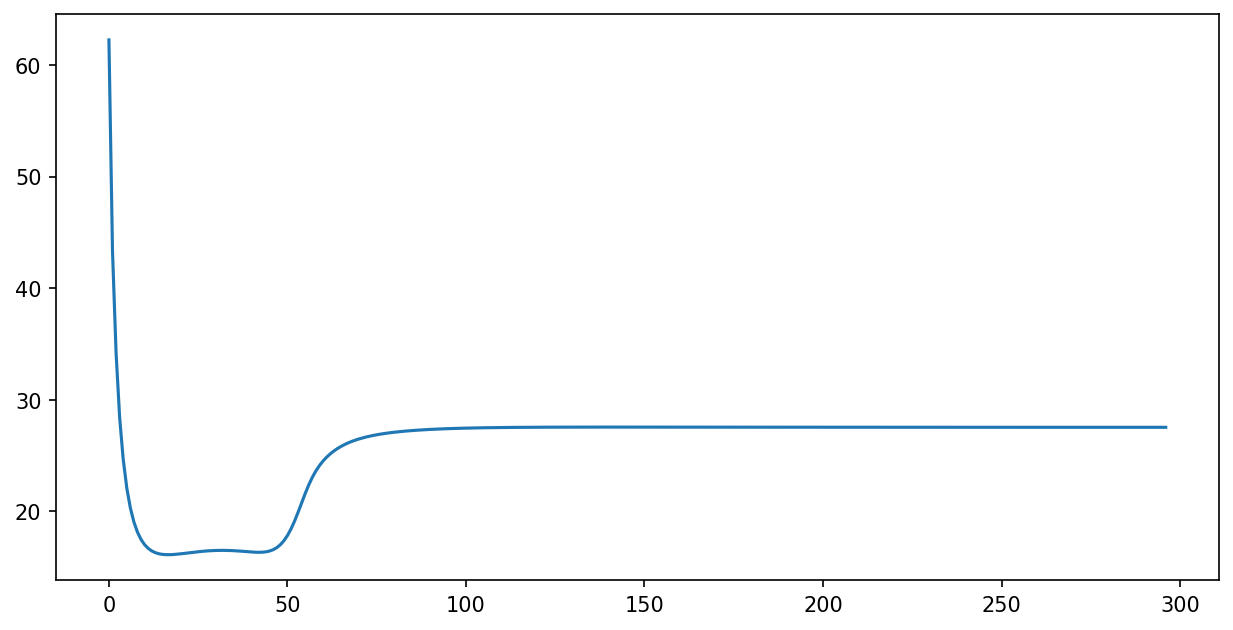

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=150)
ax.plot(log['f'])

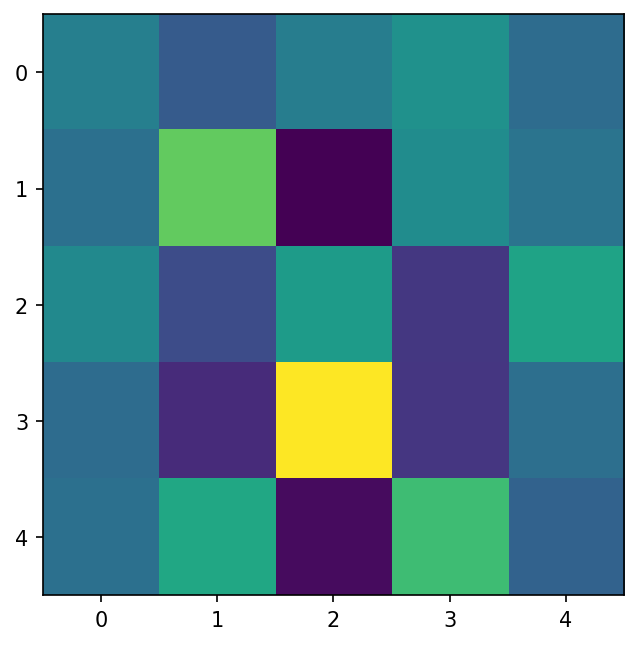

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 10), dpi=150)
plt.imshow(pi)

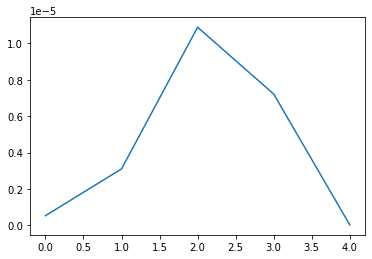

In [9]:
plt.plot(np.abs(pi.sum(-1) - a))

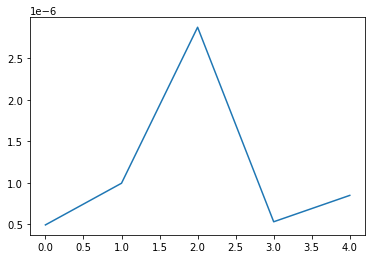

In [10]:
plt.plot(np.abs(pi.sum(0) - b))

In [11]:
U

array([[-0.4752899 ,  0.85545549],
       [-0.79000945, -0.51783592],
       [ 0.38727843, -0.00647056]])

In [12]:
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = []
for i in range(n):
    for j in range(m):
        data.append(go.Scatter3d(
            x=[X[i, 0], Y[j, 0]],
            y=[X[i, 1], Y[j, 1]],
            z=[X[i, 2], Y[j, 2]],
            line=dict(
                width=pi[i, j] * 50,
                color='black',
            ),
            marker=dict(
                size=5,
                color=['blue', 'red'],
                opacity=0.5,
            )
        ))

def get_plane(M, v, a=5):
    I = np.nonzero(v)[0]
    if len(I) == 0:
        raise ValueError('v is the null vector and cannot be the normal vec')

    D = np.dot(M, v)
    if I[0] == 0:
        y = np.linspace(-a, a, 100) 
        y, z = np.meshgrid(y, y)
        x = - (v[1]*y + v[2]*z) / v[0] + D
        return x, y, z
    elif I[0] == 1:
        x = np.linspace(-a, a, 100) 
        x, z = np.meshgrid(x, x)
        y = -(v[0]*x + v[2]*z) / v[1] + D
        return x, y, z
    else:
        x = np.linspace(-a, a, 100) 
        x, y = np.meshgrid(x, x)
        z = -(v[0]*x + v[1]*y) / v[2] + D
        return x, y, z

xp, yp, zp  = get_plane(np.zeros(3), null_space(U.T).reshape(-1))
data += [
    go.Surface(x=xp, y=yp, z=zp,
                opacity=0.1,
                showscale=False)
]

plot_figure = go.Figure(data=data, layout=layout)

plot_figure.show()

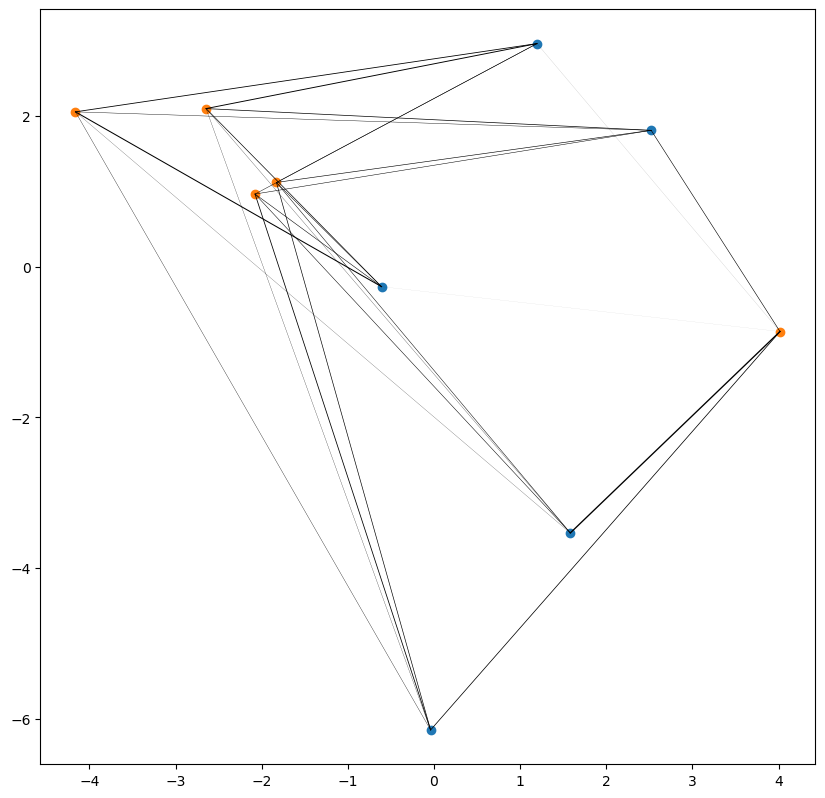

In [13]:
plt.figure(figsize=(10, 10), dpi=100)

projX = X @ U
projY = Y @ U

plt.scatter(projX[:, 0], projX[:, 1])
plt.scatter(projY[:, 0], projY[:, 1])

for i in range(n):
    for j in range(m):
        plt.plot([projX[i, 0], projY[j, 0]], 
                 [projX[i, 1], projY[j, 1]],
                 lw=pi[i, j] * 10,
                 color='black')
plt.show()